In [6]:
import os
import pandas as pd
import optuna
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW 
from torch.amp import autocast, GradScaler

from transformers import (
    DistilBertTokenizer, 
    DistilBertForSequenceClassification, 
    DistilBertConfig,
    get_linear_schedule_with_warmup 
)

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm

In [7]:
# Check for CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load and preprocess data
df = pd.read_csv("MBTI_500.csv")

# Sample 1% of the data
df_sampled = df.sample(frac=0.1, random_state=42) # <---SAMPLE-SIZE---------------------------------------------

texts = df_sampled["posts"].tolist()
labels = df_sampled["type"].tolist()

# Create a mapping of MBTI types to numerical labels
mbti_to_label = {mbti: i for i, mbti in enumerate(set(labels))}
label_to_mbti = {i: mbti for mbti, i in mbti_to_label.items()}
labels = [mbti_to_label[mbti] for mbti in labels]

# Split the data
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Create a custom dataset
class MBTIDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors="pt",
        )

        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "labels": torch.tensor(label, dtype=torch.long)
        }

# Initialize tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

Using device: cuda


In [8]:
def train_and_evaluate(config):
    # Initialize model
    model_config = DistilBertConfig.from_pretrained(
        "distilbert-base-uncased",
        num_labels=len(mbti_to_label),
        dropout=config['dropout_rate'],
    )
    model = DistilBertForSequenceClassification.from_pretrained(
        "distilbert-base-uncased",
        config=model_config,
    )
    model.to(device)

    # Create datasets and dataloaders
    train_dataset = MBTIDataset(train_texts, train_labels, tokenizer, config['max_seq_length'])
    val_dataset = MBTIDataset(val_texts, val_labels, tokenizer, config['max_seq_length'])
    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=4, pin_memory=True)

    # Initialize optimizer and scheduler
    optimizer = AdamW(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
    
    max_epochs = 7  # Fixed number of epochs for final training
    total_steps = len(train_loader) * max_epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=config['warmup_steps'], num_training_steps=total_steps)

    scaler = GradScaler()
    device_type = 'cuda' if torch.cuda.is_available() else 'cpu'

    best_f1 = 0
    best_epoch = 0
    best_accuracy = 0
    patience = 2
    no_improve = 0
    
    train_losses = []
    val_accuracies = []
    val_f1_scores = []

    for epoch in range(max_epochs):
        model.train()
        total_loss = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{max_epochs}")
        for batch in progress_bar:
            optimizer.zero_grad()
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            
            with autocast(device_type=device_type):
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                total_loss += loss.item()

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()

            progress_bar.set_postfix({"Loss": f"{loss.item():.4f}"})

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f"Average train loss: {avg_train_loss:.4f}")

        # Evaluation
        model.eval()
        val_preds = []
        val_true = []
        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validation"):
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"].to(device)
                
                outputs = model(input_ids, attention_mask=attention_mask)
                preds = torch.argmax(outputs.logits, dim=1)
                val_preds.extend(preds.cpu().tolist())
                val_true.extend(labels.cpu().tolist())

        accuracy = accuracy_score(val_true, val_preds)
        f1 = f1_score(val_true, val_preds, average="weighted")
            
        val_accuracies.append(accuracy)
        val_f1_scores.append(f1)
        
        print(f"Validation Accuracy: {accuracy:.4f}")
        print(f"Validation F1-score: {f1:.4f}")

        if f1 > best_f1:
            best_f1 = f1
            best_epoch = epoch
            best_accuracy = accuracy
            no_improve = 0
            torch.save(model.state_dict(), 'best_model.pth')
            
            # Save the best results and metrics
            best_results = {
                'config': config,
                'f1': best_f1,
                'accuracy': best_accuracy,
                'epoch': best_epoch,
                'train_losses': train_losses,
                'val_accuracies': val_accuracies,
                'val_f1_scores': val_f1_scores
            }
            torch.save(best_results, 'best_results.pth')
        else:
            no_improve += 1

        if no_improve == patience:
            print(f"Early stopping triggered after epoch {epoch + 1}")
            break
        
        # Clear CUDA cache
        torch.cuda.empty_cache()

    return best_f1, train_losses, val_accuracies, val_f1_scores, best_results

In [9]:
# Optuna hyperperimeters (auto optimization framework)
def objective(trial):
    config = {
        
        # Suggest a learning rate for the optimizer. This controls how much to change the model's weights with respect to the loss gradient.
        # It's important to choose an appropriate learning rate to ensure the model converges properly.
        'learning_rate': trial.suggest_float('learning_rate', 1e-6, 1e-4, log=True),
        
        # Suggest a batch size for training. The batch size determines the number of samples processed before the model's internal parameters are updated.
        # Larger batch sizes can lead to more stable gradient estimates but require more memory.
        'batch_size': trial.suggest_categorical('batch_size', [8, 16, 32]),
        
        # Suggest the maximum sequence length. This determines the maximum length of the input sequences.
        # Input sequences longer than this will be truncated, and shorter sequences will be padded.
        'max_seq_length': trial.suggest_categorical('max_seq_length', [128, 256, 512]),
        
        # Suggest a dropout rate. Dropout is a regularization technique where randomly selected neurons are ignored during training.
        # This helps prevent overfitting by making the network less sensitive to specific neurons.
        'dropout_rate': trial.suggest_float('dropout_rate', 0.1, 0.5),
        
        # Suggest a weight decay value. Weight decay is a regularization technique that adds a penalty for large weights to the loss function.
        # It helps prevent overfitting by encouraging the model to keep the weights small.
        'weight_decay': trial.suggest_float('weight_decay', 1e-5, 1e-3, log=True),
        
        # Suggest the number of warmup steps. Warmup steps are the initial steps during which the learning rate is gradually increased to its set value.
        # This helps in stabilizing the training process in the initial phase.
        'warmup_steps': trial.suggest_int('warmup_steps', 100, 1000),
        
    }
    
    best_f1, _, _, _, _ = train_and_evaluate(config)
    return best_f1

In [10]:
# Define the storage
storage = optuna.storages.RDBStorage(
    url="sqlite:///optuna_mbti_study.db",
    engine_kwargs={"connect_args": {"timeout": 100}}
)

# Create the study
study = optuna.create_study(
    study_name="mbti_optimization",
    storage=storage, 
    load_if_exists=True,
    direction='maximize'
)

# Continue optimization
study.optimize(objective, n_trials=1) # <-------------------------------------------------------

print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

# Train the final model with the best parameters
best_config = study.best_params
final_f1, _, _, _, best_results = train_and_evaluate(best_config)

print(f"Final F1-score with best parameters: {final_f1}")

# Load the best results (not necessary if you use the returned best_results)
# best_results = torch.load('best_results.pth')

print("\nBest Model Results:")
print(f"  Best F1-score: {best_results['f1']:.4f}")
print(f"  Best Accuracy: {best_results['accuracy']:.4f}")
print(f"  Best Epoch: {best_results['epoch']}")
print("\nBest Configuration:")
for key, value in best_results['config'].items():
    print(f"  {key}: {value}")

# Load the best model
config = DistilBertConfig.from_pretrained(
    "distilbert-base-uncased",
    num_labels=len(mbti_to_label),
    dropout=best_results['config']['dropout_rate']
)

best_model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    config=config
)
best_model.load_state_dict(torch.load('best_model.pth'))
best_model.to(device)

# Function for activity recommendation
def recommend_activity(activity_text):
    encoding = tokenizer.encode_plus(
        activity_text,
        add_special_tokens=True,
        max_length=best_results['config']['max_seq_length'],
        return_token_type_ids=False,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        return_tensors="pt",
    )
    
    input_ids = encoding["input_ids"].to(device)
    attention_mask = encoding["attention_mask"].to(device)
    
    with torch.no_grad():
        outputs = best_model(input_ids, attention_mask=attention_mask)
        pred = torch.argmax(outputs.logits, dim=1)
    
    predicted_mbti = label_to_mbti[pred.item()]
    return predicted_mbti

[I 2024-07-27 20:36:09,105] Using an existing study with name 'mbti_optimization' instead of creating a new one.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/7: 100%|██████████| 1061/1061 [01:15<00:00, 13.97it/s, Loss=2.2654]


Average train loss: 2.2285


Validation: 100%|██████████| 266/266 [00:10<00:00, 25.90it/s]


Validation Accuracy: 0.4934
Validation F1-score: 0.4368


Epoch 2/7: 100%|██████████| 1061/1061 [01:15<00:00, 14.07it/s, Loss=1.3882]


Average train loss: 1.5907


Validation: 100%|██████████| 266/266 [00:10<00:00, 24.73it/s]


Validation Accuracy: 0.6598
Validation F1-score: 0.6175


Epoch 3/7: 100%|██████████| 1061/1061 [01:13<00:00, 14.44it/s, Loss=0.2839]


Average train loss: 1.2224


Validation: 100%|██████████| 266/266 [00:10<00:00, 25.52it/s]


Validation Accuracy: 0.7003
Validation F1-score: 0.6715


Epoch 4/7: 100%|██████████| 1061/1061 [01:18<00:00, 13.52it/s, Loss=0.8908]


Average train loss: 1.0982


Validation: 100%|██████████| 266/266 [00:10<00:00, 26.23it/s]


Validation Accuracy: 0.7088
Validation F1-score: 0.6830


Epoch 5/7: 100%|██████████| 1061/1061 [01:13<00:00, 14.42it/s, Loss=0.6229]


Average train loss: 1.0336


Validation: 100%|██████████| 266/266 [00:10<00:00, 26.34it/s]


Validation Accuracy: 0.7248
Validation F1-score: 0.6990


Epoch 6/7: 100%|██████████| 1061/1061 [01:13<00:00, 14.38it/s, Loss=0.6431]


Average train loss: 0.9915


Validation: 100%|██████████| 266/266 [00:10<00:00, 26.21it/s]


Validation Accuracy: 0.7276
Validation F1-score: 0.7030


Epoch 7/7: 100%|██████████| 1061/1061 [01:13<00:00, 14.39it/s, Loss=1.2350]


Average train loss: 0.9750


Validation: 100%|██████████| 266/266 [00:10<00:00, 26.21it/s]
[I 2024-07-27 20:46:09,058] Trial 47 finished with value: 0.703006732741628 and parameters: {'learning_rate': 2.080989247644495e-06, 'batch_size': 8, 'max_seq_length': 512, 'dropout_rate': 0.12750849529932845, 'weight_decay': 1.0462566725787524e-05, 'warmup_steps': 155}. Best is trial 25 with value: 0.814281545553221.


Validation Accuracy: 0.7262
Validation F1-score: 0.7009
Best trial:
  Value:  0.814281545553221
  Params: 
    learning_rate: 2.480801070098954e-06
    batch_size: 8
    max_seq_length: 512
    dropout_rate: 0.10003471505180982
    weight_decay: 5.6230740885466525e-05
    warmup_steps: 645


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/7: 100%|██████████| 1061/1061 [01:15<00:00, 14.08it/s, Loss=2.4627]


Average train loss: 2.2848


Validation: 100%|██████████| 266/266 [00:10<00:00, 24.89it/s]


Validation Accuracy: 0.4222
Validation F1-score: 0.3379


Epoch 2/7: 100%|██████████| 1061/1061 [01:16<00:00, 13.86it/s, Loss=0.5410]


Average train loss: 1.4657


Validation: 100%|██████████| 266/266 [00:10<00:00, 26.24it/s]


Validation Accuracy: 0.6843
Validation F1-score: 0.6422


Epoch 3/7: 100%|██████████| 1061/1061 [01:16<00:00, 13.85it/s, Loss=1.6130]


Average train loss: 1.1274


Validation: 100%|██████████| 266/266 [00:10<00:00, 24.68it/s]


Validation Accuracy: 0.7168
Validation F1-score: 0.6847


Epoch 4/7: 100%|██████████| 1061/1061 [01:14<00:00, 14.15it/s, Loss=0.8862]


Average train loss: 1.0046


Validation: 100%|██████████| 266/266 [00:10<00:00, 26.19it/s]


Validation Accuracy: 0.7399
Validation F1-score: 0.7171


Epoch 5/7: 100%|██████████| 1061/1061 [01:14<00:00, 14.29it/s, Loss=0.4626]


Average train loss: 0.9387


Validation: 100%|██████████| 266/266 [00:10<00:00, 26.10it/s]


Validation Accuracy: 0.7370
Validation F1-score: 0.7147


Epoch 6/7: 100%|██████████| 1061/1061 [01:14<00:00, 14.25it/s, Loss=1.1034]


Average train loss: 0.8862


Validation: 100%|██████████| 266/266 [00:10<00:00, 26.07it/s]


Validation Accuracy: 0.7455
Validation F1-score: 0.7256


Epoch 7/7: 100%|██████████| 1061/1061 [01:14<00:00, 14.31it/s, Loss=0.4432]


Average train loss: 0.8695


Validation: 100%|██████████| 266/266 [00:10<00:00, 26.19it/s]


Validation Accuracy: 0.7455
Validation F1-score: 0.7254
Final F1-score with best parameters: 0.7255873299087396

Best Model Results:
  Best F1-score: 0.7256
  Best Accuracy: 0.7455
  Best Epoch: 5

Best Configuration:
  learning_rate: 2.480801070098954e-06
  batch_size: 8
  max_seq_length: 512
  dropout_rate: 0.10003471505180982
  weight_decay: 5.6230740885466525e-05
  warmup_steps: 645


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_802/3044872304.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted b

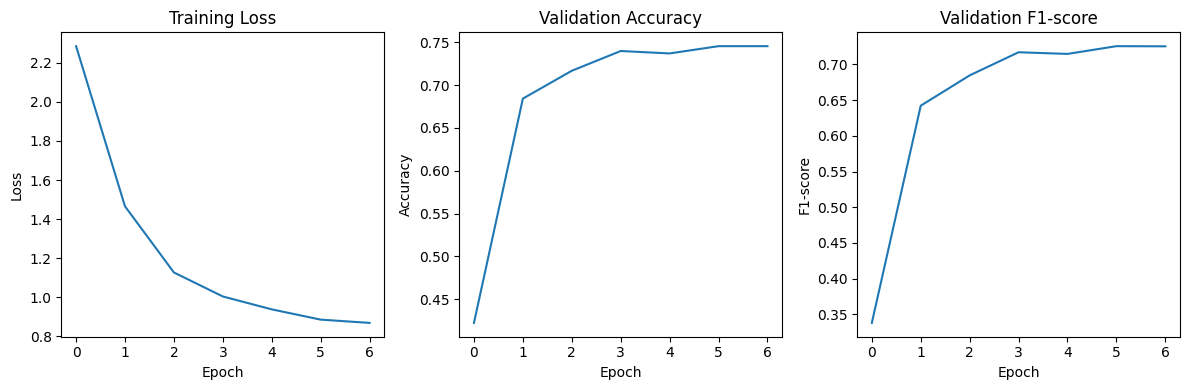

In [11]:
# Plot training progress
train_losses = best_results['train_losses']
val_accuracies = best_results['val_accuracies']
val_f1_scores = best_results['val_f1_scores']

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(train_losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 3, 2)
plt.plot(val_accuracies)
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.subplot(1, 3, 3)
plt.plot(val_f1_scores)
plt.title("Validation F1-score")
plt.xlabel("Epoch")
plt.ylabel("F1-score")

plt.tight_layout()
plt.savefig("training_progress.png")
plt.show()

In [12]:
def recommend_activity(activity_title, activity_description=None):
    max_length = best_results['config']['max_seq_length']  # Get max_length from the best configuration
    
    if activity_description:
        combined_text = f"{activity_title}: {activity_description}"
    else:
        combined_text = activity_title
    
    encoding = tokenizer.encode_plus(
        combined_text,
        add_special_tokens=True,
        max_length=max_length,
        return_token_type_ids=False,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        return_tensors="pt",
    )
    
    input_ids = encoding["input_ids"].to(device)
    attention_mask = encoding["attention_mask"].to(device)
    
    with torch.no_grad():
        outputs = best_model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=1)
        
        # Get top 2 predictions
        top_probs, top_indices = torch.topk(probabilities, 2)
        
        primary_mbti = label_to_mbti[top_indices[0][0].item()]
        secondary_mbti = label_to_mbti[top_indices[0][1].item()]
        confidence = top_probs[0][0].item()
        
        # If the confidence is high, return only the primary MBTI
        if confidence > 0.8:
            return primary_mbti, None, confidence
        else:
            return primary_mbti, secondary_mbti, confidence

In [13]:
# Example usage with lists
activity_titles = [
    "Strategic Planning Workshop", # INTJ
    "Science Fiction Film Screening", # INTP
    "Leadership Seminar", # ENTJ
    "Innovative Startup Pitch Night at Singapore's One-North", # ENTP
    "Mindfulness and Meditation Session", # INFJ
    "Poetry and Creative Writing Meetup", # INFP
    "Community Service and Outreach Program", # ENFJ
    "Art Therapy Workshop", # ENFP
    "Historical Tour of Singapore's Colonial District", # ISTJ
    "Charity Bake Sale", # ISFJ
    "Business Networking Event at Raffles Place", # ESTJ
    "Social Dance Class", # ESFJ
    "Adventure Sports Day", # ISTP
    "Photography Walk at Marina Bay", # ISFP
    "Urban Exploration Challenge: Uncovering Singapore's Hidden Gems", # ESTP
    "Outdoor Music Festival" # ESFP
]

activity_descriptions = [
    "Join fellow visionaries for a strategic planning workshop focused on achieving long-term goals.",
    "Enjoy a screening of classic and modern science fiction films followed by a discussion on futuristic concepts.",
    "Participate in a seminar designed for aspiring leaders to enhance their management and leadership skills.",
    "Pitch your innovative startup ideas and receive feedback from experienced entrepreneurs.",
    "Experience a serene mindfulness and meditation session to rejuvenate your mind and soul.",
    "Express your creativity in our poetry and creative writing meetup. Share your work and get inspired by others.",
    "Engage in community service and outreach to make a positive impact in your local neighborhood.",
    "Discover the therapeutic benefits of art in our guided art therapy workshop.",
    "Explore Singapore's rich history with a guided tour of iconic landmarks and heritage sites.",
    "Bake and sell delicious treats at our charity bake sale to support local causes.",
    "Network with professionals and expand your business connections at our networking event.",
    "Learn and enjoy various dance styles in our social dance class. No prior experience required.",
    "Challenge yourself with thrilling adventure sports activities in various locations around Singapore.",
    "Capture the beauty of Marina Bay in a photography walk and share your best shots with the group.",
    "Compete in an exciting urban exploration challenge, discovering hidden gems around the city.",
    "Enjoy live music performances from local and international artists at our outdoor music festival."
]

# Ensure the lists have the same length
assert len(activity_titles) == len(activity_descriptions), "Lists must have the same length"

for title, description in zip(activity_titles, activity_descriptions):
    result = recommend_activity(title, description)

    if len(result) == 3:
        mbti, second_mbti, confidence = result
        print(f"\nActivity: {title}")
        print(f"Description: {description}")
        if second_mbti:
            print(f"Recommended MBTI types: {mbti} and {second_mbti}")
            print(f"Confidence: {confidence:.2f}")
        else:
            print(f"Recommended MBTI type: {mbti}")
            print(f"Confidence: {confidence:.2f}")


Activity: Strategic Planning Workshop
Description: Join fellow visionaries for a strategic planning workshop focused on achieving long-term goals.
Recommended MBTI types: INTJ and INTP
Confidence: 0.10

Activity: Science Fiction Film Screening
Description: Enjoy a screening of classic and modern science fiction films followed by a discussion on futuristic concepts.
Recommended MBTI types: INTP and INFP
Confidence: 0.09

Activity: Leadership Seminar
Description: Participate in a seminar designed for aspiring leaders to enhance their management and leadership skills.
Recommended MBTI types: INTJ and INTP
Confidence: 0.11

Activity: Innovative Startup Pitch Night at Singapore's One-North
Description: Pitch your innovative startup ideas and receive feedback from experienced entrepreneurs.
Recommended MBTI types: INTJ and INFP
Confidence: 0.10

Activity: Mindfulness and Meditation Session
Description: Experience a serene mindfulness and meditation session to rejuvenate your mind and soul.


In [14]:
# Example usage
activity_title = "Ocean, Rose, Mountain, Sky"
activity_description = ""

result = recommend_activity(activity_title, activity_description)

if len(result) == 3:
    mbti, second_mbti, confidence = result
    if second_mbti:
        print(f"The activity '{activity_title}' is recommended for MBTI types: {mbti} and {second_mbti}")
        print(f"Confidence: {confidence:.2f}")
    else:
        print(f"The activity '{activity_title}' is recommended for MBTI type: {mbti}")
        print(f"Confidence: {confidence:.2f}")

The activity 'Ocean, Rose, Mountain, Sky' is recommended for MBTI types: INTP and INTJ
Confidence: 0.11


In [15]:
import torch
from transformers import DistilBertTokenizer, DistilBertForMaskedLM

# Make sure to use the same tokenizer as you used for training
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# Load the masked language model
mlm_model = DistilBertForMaskedLM.from_pretrained("distilbert-base-uncased")
mlm_model.to(device)
mlm_model.eval()

def generate_associated_words(mbti_type, num_words=5):
    # Create a template sentence
    template = f"People with MBTI type {mbti_type} strongly associate with the word [MASK]."
    
    # Tokenize the template
    inputs = tokenizer(template, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # Find the position of the [MASK] token
    mask_token_index = torch.where(inputs["input_ids"] == tokenizer.mask_token_id)[1]
    
    associated_words = []
    
    with torch.no_grad():
        for _ in range(num_words):
            outputs = mlm_model(**inputs)
            logits = outputs.logits
            
            # Get the logits for the mask token
            mask_token_logits = logits[0, mask_token_index, :]
            
            # Remove previously selected words
            for word in associated_words:
                word_id = tokenizer.encode(word, add_special_tokens=False)[0]
                mask_token_logits[0, word_id] = float('-inf')
            
            # Get the top predicted token
            top_token = torch.argmax(mask_token_logits, dim=1)
            
            # Convert token to word
            predicted_token = top_token.item()  # Convert to Python integer
            predicted_word = tokenizer.decode([predicted_token])
            associated_words.append(predicted_word)
    
    return associated_words

# List of all 16 MBTI types
mbti_types = [
    "INTJ", "INTP", "ENTJ", "ENTP",
    "INFJ", "INFP", "ENFJ", "ENFP",
    "ISTJ", "ISFJ", "ESTJ", "ESFJ",
    "ISTP", "ISFP", "ESTP", "ESFP"
]

# Generate associated words for each MBTI type
for mbti in mbti_types:
    words = generate_associated_words(mbti)
    print(f"{mbti}: {', '.join(words)}")

INTJ: noun, [UNK], mutation, type, processor
INTP: processor, noun, mutation, prefix, type
ENTJ: noun, zulu, mb, [UNK], mutation
ENTP: noun, processor, itself, type, prefix
INFJ: noun, mutation, zulu, mb, type
INFP: noun, zulu, language, word, mb
ENFJ: noun, zulu, mutation, mb, mate
ENFP: noun, zulu, word, language, mb
ISTJ: noun, zulu, [UNK], mate, prefix
ISFJ: zulu, noun, mb, type, mutation
ESTJ: noun, mate, zulu, [UNK], mutation
ESFJ: zulu, noun, mate, mutation, mb
ISTP: noun, processor, prefix, zulu, language
ISFP: noun, zulu, language, word, mb
ESTP: noun, mutation, prefix, language, mate
ESFP: processor, zulu, mate, noun, type


In [25]:
# Prompt user for confirmation
user_input = input("Train the final model with the best parameters? (Y/N): ")

if user_input.lower() == 'y':
    print("Training final model with best parameters...")
    best_params = study.best_params
    print("Best parameters:", best_params)

    num_epochs = 30

    def train_final_model(best_params, full_dataset, num_epochs):
        # Initialize model
        model_config = DistilBertConfig.from_pretrained(
            "distilbert-base-uncased",
            num_labels=len(mbti_to_label),
            dropout=best_params['dropout_rate'],
        )
        model = DistilBertForSequenceClassification.from_pretrained(
            "distilbert-base-uncased",
            config=model_config,
        )
        model.to(device)

        # Create datasets and dataloaders
        dataset = MBTIDataset(full_dataset['texts'], full_dataset['labels'], tokenizer, best_params['max_seq_length'])
        train_size = int(0.8 * len(dataset))
        val_size = len(dataset) - train_size
        train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
        
        train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True, num_workers=4, pin_memory=True)
        val_loader = DataLoader(val_dataset, batch_size=best_params['batch_size'], shuffle=False, num_workers=4, pin_memory=True)

        # Initialize optimizer and scheduler
        optimizer = AdamW(model.parameters(), lr=best_params['learning_rate'], weight_decay=best_params['weight_decay'])
        
        total_steps = len(train_loader) * num_epochs
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=best_params['warmup_steps'], num_training_steps=total_steps)

        scaler = GradScaler()

        best_val_f1 = 0
        patience = 3
        no_improve = 0

        for epoch in range(num_epochs):
            model.train()
            total_loss = 0
            progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}")
            for batch in progress_bar:
                optimizer.zero_grad()
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"].to(device)
                
                with torch.amp.autocast(device_type='cuda'):
                    outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                    loss = outputs.loss

                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
                scheduler.step()

                total_loss += loss.item()
                progress_bar.set_postfix({"Loss": f"{loss.item():.4f}"})

            avg_train_loss = total_loss / len(train_loader)
            print(f"Epoch {epoch + 1}/{num_epochs}, Average train loss: {avg_train_loss:.4f}")

            # Validation
            model.eval()
            val_preds = []
            val_true = []
            with torch.no_grad():
                for batch in tqdm(val_loader, desc="Validation"):
                    input_ids = batch["input_ids"].to(device)
                    attention_mask = batch["attention_mask"].to(device)
                    labels = batch["labels"].to(device)
                    
                    outputs = model(input_ids, attention_mask=attention_mask)
                    preds = torch.argmax(outputs.logits, dim=1)
                    val_preds.extend(preds.cpu().tolist())
                    val_true.extend(labels.cpu().tolist())

            accuracy = accuracy_score(val_true, val_preds)
            f1 = f1_score(val_true, val_preds, average="weighted")
            
            print(f"Validation Accuracy: {accuracy:.4f}")
            print(f"Validation F1-score: {f1:.4f}")

            # Early stopping
            if f1 > best_val_f1:
                best_val_f1 = f1
                no_improve = 0
                torch.save(model.state_dict(), 'best_final_model.pth')
            else:
                no_improve += 1

            if no_improve == patience:
                print(f"Early stopping triggered after epoch {epoch + 1}")
                break

        # Load the best model before returning
        model.load_state_dict(torch.load('best_final_model.pth'))
        return model

    # Prepare your full dataset
    full_dataset = {
        'texts': df["posts"].tolist(),
        'labels': [mbti_to_label[mbti] for mbti in df["type"].tolist()]
    }

    # Train the final model
    final_model = train_final_model(best_params, full_dataset, num_epochs)

    # Save the final model
    torch.save(final_model.state_dict(), 'final_mbti_model.pth')

    print("Final model trained and saved.")

else:
    print("Final model training cancelled.")

Training final model with best parameters...
Best parameters: {'learning_rate': 2.480801070098954e-06, 'batch_size': 8, 'max_seq_length': 512, 'dropout_rate': 0.10003471505180982, 'weight_decay': 5.6230740885466525e-05, 'warmup_steps': 645}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/30: 100%|██████████| 10607/10607 [12:04<00:00, 14.64it/s, Loss=0.6169]


Epoch 1/30, Average train loss: 1.1079


Validation: 100%|██████████| 2652/2652 [01:38<00:00, 26.99it/s]


Validation Accuracy: 0.7889
Validation F1-score: 0.7820


Epoch 2/30: 100%|██████████| 10607/10607 [12:03<00:00, 14.66it/s, Loss=0.2391]


Epoch 2/30, Average train loss: 0.6715


Validation: 100%|██████████| 2652/2652 [01:38<00:00, 27.05it/s]


Validation Accuracy: 0.8108
Validation F1-score: 0.8100


Epoch 3/30: 100%|██████████| 10607/10607 [12:04<00:00, 14.65it/s, Loss=0.2637] 


Epoch 3/30, Average train loss: 0.5810


Validation: 100%|██████████| 2652/2652 [01:37<00:00, 27.13it/s]


Validation Accuracy: 0.8144
Validation F1-score: 0.8144


Epoch 4/30: 100%|██████████| 10607/10607 [11:59<00:00, 14.75it/s, Loss=0.1499]


Epoch 4/30, Average train loss: 0.5186


Validation: 100%|██████████| 2652/2652 [01:37<00:00, 27.16it/s]


Validation Accuracy: 0.8344
Validation F1-score: 0.8342


Epoch 5/30: 100%|██████████| 10607/10607 [11:58<00:00, 14.77it/s, Loss=0.0770]


Epoch 5/30, Average train loss: 0.4702


Validation: 100%|██████████| 2652/2652 [01:37<00:00, 27.23it/s]


Validation Accuracy: 0.8375
Validation F1-score: 0.8371


Epoch 6/30: 100%|██████████| 10607/10607 [11:56<00:00, 14.81it/s, Loss=0.7089]


Epoch 6/30, Average train loss: 0.4313


Validation: 100%|██████████| 2652/2652 [01:37<00:00, 27.27it/s]


Validation Accuracy: 0.8451
Validation F1-score: 0.8446


Epoch 7/30: 100%|██████████| 10607/10607 [11:56<00:00, 14.81it/s, Loss=0.6251]


Epoch 7/30, Average train loss: 0.3896


Validation: 100%|██████████| 2652/2652 [01:36<00:00, 27.43it/s]


Validation Accuracy: 0.8471
Validation F1-score: 0.8468


Epoch 8/30: 100%|██████████| 10607/10607 [11:59<00:00, 14.75it/s, Loss=1.1793]


Epoch 8/30, Average train loss: 0.3592


Validation: 100%|██████████| 2652/2652 [01:38<00:00, 27.04it/s]


Validation Accuracy: 0.8426
Validation F1-score: 0.8431


Epoch 9/30: 100%|██████████| 10607/10607 [12:12<00:00, 14.48it/s, Loss=0.0096]


Epoch 9/30, Average train loss: 0.3265


Validation: 100%|██████████| 2652/2652 [01:38<00:00, 27.06it/s]


Validation Accuracy: 0.8479
Validation F1-score: 0.8475


Epoch 10/30: 100%|██████████| 10607/10607 [12:12<00:00, 14.49it/s, Loss=0.4983]


Epoch 10/30, Average train loss: 0.2981


Validation: 100%|██████████| 2652/2652 [01:37<00:00, 27.09it/s]


Validation Accuracy: 0.8474
Validation F1-score: 0.8476


Epoch 11/30: 100%|██████████| 10607/10607 [12:08<00:00, 14.55it/s, Loss=0.4947]


Epoch 11/30, Average train loss: 0.2708


Validation: 100%|██████████| 2652/2652 [01:37<00:00, 27.14it/s]


Validation Accuracy: 0.8458
Validation F1-score: 0.8454


Epoch 12/30: 100%|██████████| 10607/10607 [12:08<00:00, 14.55it/s, Loss=0.0039]


Epoch 12/30, Average train loss: 0.2464


Validation: 100%|██████████| 2652/2652 [01:37<00:00, 27.18it/s]


Validation Accuracy: 0.8507
Validation F1-score: 0.8501


Epoch 13/30: 100%|██████████| 10607/10607 [12:09<00:00, 14.54it/s, Loss=0.0438]


Epoch 13/30, Average train loss: 0.2250


Validation: 100%|██████████| 2652/2652 [01:37<00:00, 27.25it/s]


Validation Accuracy: 0.8456
Validation F1-score: 0.8458


Epoch 14/30: 100%|██████████| 10607/10607 [12:10<00:00, 14.52it/s, Loss=0.2511]


Epoch 14/30, Average train loss: 0.2008


Validation: 100%|██████████| 2652/2652 [01:37<00:00, 27.19it/s]


Validation Accuracy: 0.8415
Validation F1-score: 0.8422


Epoch 15/30: 100%|██████████| 10607/10607 [12:21<00:00, 14.30it/s, Loss=0.3176]


Epoch 15/30, Average train loss: 0.1827


Validation: 100%|██████████| 2652/2652 [01:36<00:00, 27.40it/s]
/tmp/ipykernel_802/2168726522.py:104: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(tor

Validation Accuracy: 0.8406
Validation F1-score: 0.8416
Early stopping triggered after epoch 15
Final model trained and saved.


In [27]:
def predict_mbti(text, model, tokenizer):
    model.eval()
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=best_params['max_seq_length'])
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        outputs = model(**inputs)
        prediction = torch.argmax(outputs.logits, dim=1).item()
    
    return label_to_mbti[prediction]

# Example usage
text = "I enjoy solving complex problems and working independently."
predicted_mbti = predict_mbti(text, final_model, tokenizer)
print(f"Predicted MBTI for example text: {predicted_mbti}")

Predicted MBTI for example text: INTJ
